Train label distribution: {'transmission with teeth-uncompleted gears': 1500, 'oval gear': 1108, 'spatial slider crank mechanism': 376, 'parallelogram mechanism': 296, 'one way clutch': 231, 'ratchet mechanism': 204, 'chain drive': 141}
Val label distribution: {'transmission with teeth-uncompleted gears': 610, 'oval gear': 201, 'parallelogram mechanism': 59, 'one way clutch': 34, 'chain drive': 28, 'spatial slider crank mechanism': 17, 'ratchet mechanism': 10}
Test label distribution: {'transmission with teeth-uncompleted gears': 608, 'oval gear': 210, 'parallelogram mechanism': 52, 'one way clutch': 32, 'spatial slider crank mechanism': 22, 'ratchet mechanism': 22, 'chain drive': 21}
Class weights: [0.49716347455978394, 2.70028018951416, 1.8610038757324219, 1.4650455713272095, 3.9067883491516113, 2.3846628665924072, 0.3672381043434143]
Epoch 1: Train Loss 1.3480, Val Loss 0.8826, Train Acc 0.2484, Val Acc 0.0542
Epoch 2: Train Loss 1.0087, Val Loss 0.6440, Train Acc 0.3076, Val Acc 0.

C:\Users\shrin\AppData\Local\Temp\ipykernel_26644\1917375628.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_focal.pth', m

Test Loss: 0.3813
Test Accuracy: 0.6960
Precision: 0.7502, Recall: 0.6960, F1: 0.7110
Confusion Matrix:
 [[150   2   3   1   6   5  43]
 [  3  16   0   0   0   0   3]
 [  1   0  33   0   0   0  18]
 [  1   0   3  12   0   0   6]
 [  0   0   1   0  20   0   0]
 [  3   0   0   0   0  24   5]
 [ 56   5  55  19  21  34 418]]

=== Classification Report ===
                                           precision    recall  f1-score   support

                                oval gear     0.7009    0.7143    0.7075       210
                        ratchet mechanism     0.6957    0.7273    0.7111        22
                  parallelogram mechanism     0.3474    0.6346    0.4490        52
           spatial slider crank mechanism     0.3750    0.5455    0.4444        22
                              chain drive     0.4255    0.9524    0.5882        21
                           one way clutch     0.3810    0.7500    0.5053        32
transmission with teeth-uncompleted gears     0.8479    0.6875  

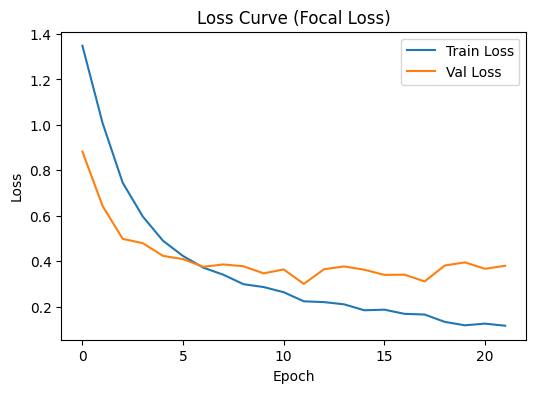

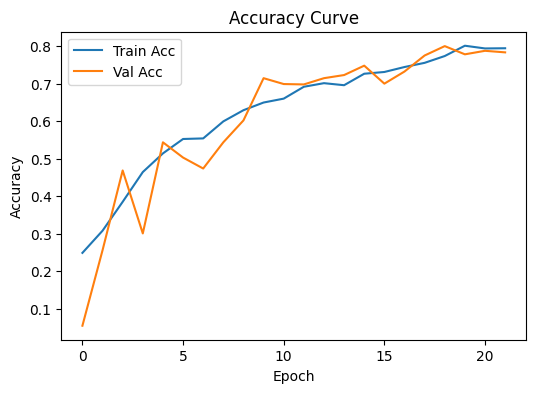

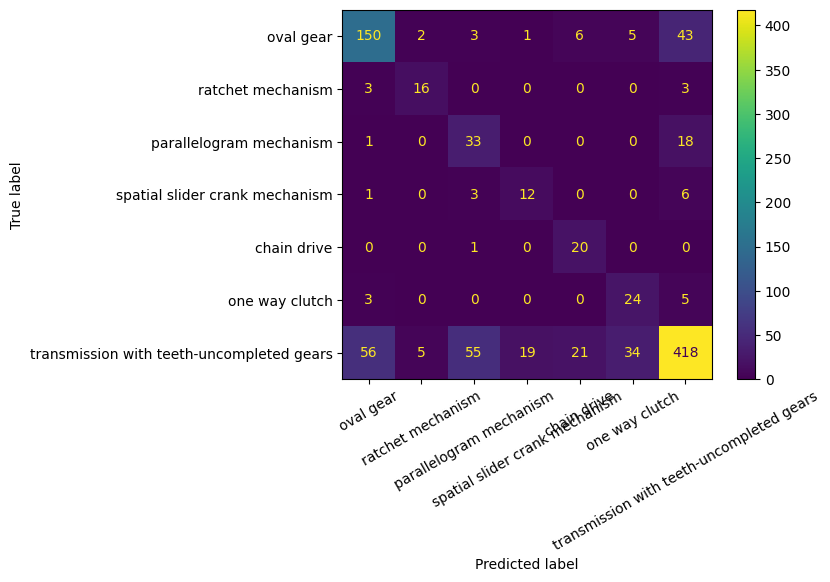

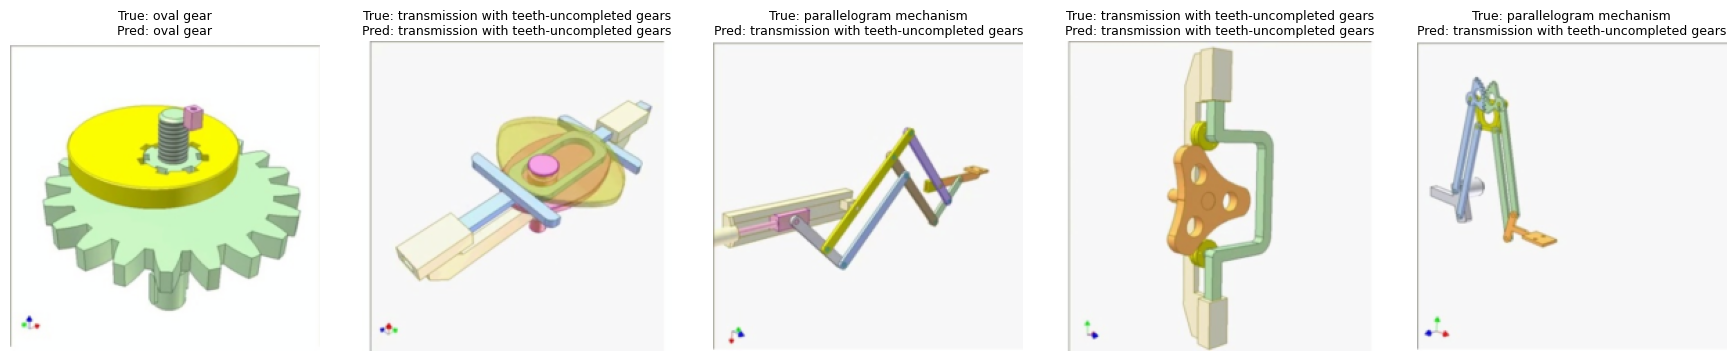

In [ ]:

import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import matplotlib.pyplot as plt

# =========================================================
# 1. Load CSV and Folder Paths
# =========================================================
metadata_path = r"C:\Users\shrin\OneDrive\Desktop\DL_3\fully_updated.csv"
data_root     = r"C:\Users\shrin\OneDrive\Desktop\DL_3\_2_dataset"

train_dir = os.path.join(data_root, "train")
val_dir   = os.path.join(data_root, "val")
test_dir  = os.path.join(data_root, "test")

df = pd.read_csv(metadata_path)

# Filter for 3D images
df = df[df["Sketch Type"].str.contains("3D", case=False, na=False)].reset_index(drop=True)
assert len(df) > 0, "No rows with Sketch Type == '3D' found!"

# Encode classes
class2idx = {c: i for i, c in enumerate(df['Class'].unique())}
idx2class = {i: c for c, i in class2idx.items()}
df['class_idx'] = df['Class'].map(class2idx)
num_classes = len(class2idx)

# Use existing split column
train_df = df[df["split"] == "train"].reset_index(drop=True)
val_df   = df[df["split"] == "val"].reset_index(drop=True)
test_df  = df[df["split"] == "test"].reset_index(drop=True)

# Print counts and sanity check
print("Train label distribution:", train_df['Class'].value_counts().to_dict())
print("Val label distribution:", val_df['Class'].value_counts().to_dict())
print("Test label distribution:", test_df['Class'].value_counts().to_dict())

# =========================================================
# 2. Transforms
# =========================================================
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.15,0.15), scale=(0.9,1.1)),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# =========================================================
# 3. Custom Dataset Class
# =========================================================
class MechDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fname = self.df.loc[idx, 'File Name']
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.df.loc[idx, 'class_idx']
        return image, label

# =========================================================
# 4. Datasets + Loaders
# =========================================================
train_set = MechDataset(train_df, train_dir, transform=train_transform)
val_set   = MechDataset(val_df, val_dir, transform=eval_transform)
test_set  = MechDataset(test_df, test_dir, transform=eval_transform)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=16, shuffle=False)

# =========================================================
# 5. Class weights
# =========================================================
all_train_labels = train_df['class_idx'].values
class_weights = compute_class_weight('balanced', classes=np.unique(all_train_labels), y=all_train_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights.tolist())

# =========================================================
# 6. Focal Loss
# =========================================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.ce = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce(inputs, targets)
        pt = torch.exp(-ce_loss)  # p_t = softmax prob of true class
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# =========================================================
# 7. Model
# =========================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.googlenet(weights=models._Weights.IMAGENET1K_V1)

# Replace final classifier
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, num_classes)
)

model = model.to(device)
# =========================================================
# 8. Training setup
# =========================================================
criterion = FocalLoss(alpha=class_weights.to(device), gamma=2.0)
optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.7)

best_val_loss = float('inf')
patience = 10
epochs_no_improve = 0
n_epochs = 100

train_losses, val_losses, train_accs, val_accs = [], [], [], []

# =========================================================
# 9. Training Loop
# =========================================================
for epoch in range(n_epochs):
    model.train()
    running_loss, total, correct = 0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
        _, preds = torch.max(out, 1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    model.eval()
    val_loss_sum, val_total, val_correct = 0, 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            out_val = model(X_val)
            loss_val = criterion(out_val, y_val)
            val_loss_sum += loss_val.item() * X_val.size(0)
            _, preds_val = torch.max(out_val, 1)
            val_correct += (preds_val == y_val).sum().item()
            val_total += y_val.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}: Train Loss {train_loss:.4f}, Val Loss {val_loss:.4f}, "
          f"Train Acc {train_acc:.4f}, Val Acc {val_acc:.4f}")

    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model_focal.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break

print(f"Final Train Accuracy: {train_accs[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accs[-1]:.4f}")

# =========================================================
# 10. Test Evaluation
# =========================================================
model.load_state_dict(torch.load('best_model_focal.pth', map_location=device))
model.eval()
y_true, y_pred, test_loss_sum, test_total = [], [], 0, 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = criterion(out, y)
        test_loss_sum += loss.item() * X.size(0)
        preds = torch.argmax(out, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.cpu().numpy())
        test_total += y.size(0)

test_loss = test_loss_sum / test_total
accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
conf_mat = confusion_matrix(y_true, y_pred)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print("Confusion Matrix:\n", conf_mat)

# ---- New Section: Per-Class Classification Report ----
report = classification_report(
    y_true,
    y_pred,
    target_names=[idx2class[i] for i in range(len(idx2class))],
    digits=4
)
print("\n=== Classification Report ===")
print(report)

# Save to text file
with open("classification_report.txt", "w") as f:
    f.write(report)
    
# =========================================================
# 11. Plots
# =========================================================
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve (Focal Loss)')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.show()

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=[idx2class[i] for i in range(len(idx2class))])
disp.plot(xticks_rotation=30)
plt.show()

# =========================================================
# 12. Sample Predictions
# =========================================================
plt.figure(figsize=(18, 6))
indices = [0, 1, 2, 3, 4]
for i, idx in enumerate(indices):
    img, label = test_set[idx]
    with torch.no_grad():
        pred = torch.argmax(model(img.unsqueeze(0).to(device))).cpu().item()
    plt.subplot(1, 5, i+1)
    img_for_view = img.numpy().transpose(1,2,0) * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406])
    img_for_view = np.clip(img_for_view, 0, 1)
    plt.imshow(img_for_view)
    plt.title(f"True: {idx2class[label]}\nPred: {idx2class[pred]}", fontsize=9, wrap=True)
    plt.axis('off')
plt.tight_layout(pad=3.0)
plt.show()





